In [12]:
import numpy as np
b=np.load('ny.eater-content-new.npy')
content=b.tolist()

In [11]:
content

[['Zhen Wei Fang and Tang Hotpot are powered by flashy decor, a robust suite of meats, and complex, flavorful broths',
  'The most useful thing to know about Vandal, a bacchanalian Bowery temple to viral foods, faux street art, and a basic cocaine lifestyle, is that it’s adjacent to another let’s-have-a-long-night-out spot that’s actually worth visiting. Zhen Wei Fang, backed by Wei Chen and the Congee Village team, pairs its pristine hot pot fare with an absolutely wild environment. ',
  'A robot host greets guests in Mandarin. Mixed martial arts matches play on four televisions. Michael Jackson pumps through the sound system. Multitiered meat trays rise 3 feet above every table, flaunting vertical croppings of raw lamb, beef, and tofu skin. Diners use chopsticks to plunge red ribbons of New Zealand lamb ($15) into white bone broth, turning the flesh brown, soft, and succulent. You slurp the meat almost as easily as you would a noodle. ',
  'Want to combine hot pot with a few hours of

In [63]:
import pandas as pd 
pd.DataFrame(b).to_csv("ny.eater-content-new.csv")

In [13]:
import re  # For preprocessing
import pandas as pd  # For data handling
from time import time  # To time our operations
from collections import defaultdict  # For word frequency

import spacy  # For preprocessing

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

In [14]:
nlp = spacy.load('en', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed

In [15]:
def cleaning(doc):
    # Lemmatizes and removes stopwords
    # doc needs to be a spacy Doc object
    txt = [token.lemma_ for token in doc if not token.is_stop]
    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long,
    # the benefit for the training is very small
    if len(txt) > 2:
        return ' '.join(txt)

new_content = []
for article in content:
    if article != []:
        text = ""
        for sent in article:
            text = text + sent
        new_content.append(text)

    

In [5]:
nlp.max_length = 3000200

In [6]:
a=''
for each in df_clean['clean']:
    a += each


NameError: name 'df_clean' is not defined

In [7]:
doc1 = nlp(a)

In [121]:
len(set(doc1))

286654

In [122]:
len(set(doc1))/len(a)

0.15004504167336227

In [16]:
brief_cleaning = (re.sub("[^A-Za-z']+", ' ', re.sub("'s", '', re.sub("’s", '',str(article)))).lower() for article in new_content)

t = time()

txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000, n_threads=-1)]

print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
df_clean.shape

Time to clean up everything: 0.4 mins


(395, 1)

In [17]:
df_clean[30:]

,clean
30,spa heal body outside deliver city satisfy bor...
31,inventive pan regional cooking herald new kind...
32,tiny cobble hill restaurant bring inventive co...
33,didn t university california berkeley cal nati...
34,decade sleepy central richmond culinary option...
35,exclusive williamsburg restaurant rare miss ch...
36,airy plant strew restaurant isa alum excitemen...
37,old laundromat get new lease urban life lately...
38,restaurant define view waterfront restaurant r...
39,crackle pork belly crunchy squid beautifully s...


In [114]:
# df_clean['clean'][0]

In [75]:
# wordNum=0
# count=0
# for j in df_clean['clean']:
#     wordNum =wordNum + len(j)
#     count = count + 1
# print(wordNum/count)    
    

4853.463291139241


In [18]:
from gensim.models.phrases import Phrases, Phraser

In [19]:
sent = [row.split() for row in df_clean['clean']]

In [20]:
bigram = Phrases(sent, min_count=30, progress_per=10000)

INFO - 13:19:54: collecting all words and their counts
INFO - 13:19:54: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 13:19:55: collected 239572 word types from a corpus of 283344 words (unigram + bigrams) and 395 sentences
INFO - 13:19:55: using 239572 counts as vocab in Phrases<0 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000>


In [21]:
sentences = bigram[sent]

In [22]:
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

22942

In [23]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['restaurant',
 'like',
 'dish',
 'good',
 'menu',
 'food',
 'chef',
 'come',
 'flavor',
 'chicken']

In [24]:
import numpy as np
import pandas as pd

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import spacy
from spacy.lemmatizer import Lemmatizer
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_lg

from tqdm import tqdm_notebook as tqdm
from pprint import pprint

In [25]:
doc_list=sentences
# Creates, which is a mapping of word IDs to words.
words = corpora.Dictionary(doc_list)

# Turns each document into a bag of words.
corpus = [words.doc2bow(doc) for doc in doc_list]

INFO - 13:19:56: adding document #0 to Dictionary(0 unique tokens: [])
INFO - 13:19:57: built Dictionary(22942 unique tokens: ['abalone', 'absolutely', 'absurd', 'accessible', 'acidity']...) from 395 documents (total 275313 corpus positions)


In [26]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=words,
                                           num_topics=20, 
                                           random_state=2,
                                           update_every=1,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

INFO - 13:19:58: using autotuned alpha, starting with [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]
INFO - 13:19:58: using symmetric eta at 0.05
INFO - 13:19:58: using serial LDA version on this node
INFO - 13:19:59: running online (multi-pass) LDA training, 20 topics, 10 passes over the supplied corpus of 395 documents, updating model once every 395 documents, evaluating perplexity every 395 documents, iterating 50x with a convergence threshold of 0.001000
INFO - 13:20:02: -13.429 per-word bound, 11032.3 perplexity estimate based on a held-out corpus of 395 documents with 275313 words
INFO - 13:20:02: PROGRESS: pass 0, at document #395/395
INFO - 13:20:05: optimized alpha [0.09346892, 0.09309897, 0.09423925, 0.094810836, 0.0932745, 0.09369795, 0.08834974, 0.090643354, 0.09448183, 0.09388143, 0.08897023, 0.09605072, 0.0954025, 0.09496476, 0.09458937, 0.09035362, 0.09659594, 0.09462388, 0.094126776, 0.094926566]


INFO - 13:20:32: topic #15 (0.032): 0.007*"tajine" + 0.004*"couscous" + 0.003*"omar" + 0.002*"chicken" + 0.002*"algerian" + 0.002*"bastilla" + 0.002*"north" + 0.002*"french" + 0.002*"restaurant" + 0.002*"african"
INFO - 13:20:32: topic #6 (0.032): 0.008*"curry" + 0.007*"sri" + 0.006*"lankan" + 0.004*"hopper" + 0.004*"san" + 0.004*"rasa" + 0.004*"chicken" + 0.003*"fish" + 0.003*"roti" + 0.003*"joe"
INFO - 13:20:32: topic #12 (0.051): 0.007*"restaurant" + 0.006*"like" + 0.005*"good" + 0.004*"dish" + 0.004*"food" + 0.003*"sauce" + 0.003*"meat" + 0.003*"sweet" + 0.003*"come" + 0.003*"chef"
INFO - 13:20:32: topic #11 (0.076): 0.010*"restaurant" + 0.006*"like" + 0.006*"dish" + 0.004*"menu" + 0.004*"food" + 0.004*"include" + 0.004*"chicken" + 0.004*"good" + 0.003*"open" + 0.003*"fry"
INFO - 13:20:32: topic #16 (0.178): 0.008*"restaurant" + 0.006*"like" + 0.005*"dish" + 0.004*"chef" + 0.004*"good" + 0.004*"menu" + 0.003*"food" + 0.003*"come" + 0.003*"bar" + 0.003*"flavor"
INFO - 13:20:32: topi

In [27]:
pprint(lda_model.print_topics(num_words=20))

INFO - 13:22:10: topic #0 (0.026): 0.007*"restaurant" + 0.005*"not" + 0.005*"good" + 0.005*"like" + 0.004*"spot" + 0.004*"cardoz" + 0.004*"carbone" + 0.004*"white" + 0.004*"beef" + 0.003*"bread"
INFO - 13:22:10: topic #1 (0.027): 0.010*"like" + 0.009*"drink" + 0.008*"chicken" + 0.008*"sample_dish" + 0.007*"sauce" + 0.006*"salad" + 0.006*"dish" + 0.006*"sandwich" + 0.006*"cheese" + 0.005*"beer"
INFO - 13:22:10: topic #2 (0.029): 0.007*"pizza" + 0.006*"like" + 0.005*"pie" + 0.005*"restaurant" + 0.005*"wine" + 0.005*"menu" + 0.004*"open" + 0.004*"good" + 0.004*"chef" + 0.004*"expect"
INFO - 13:22:10: topic #3 (0.029): 0.004*"dish" + 0.004*"taco" + 0.004*"price" + 0.004*"restaurant" + 0.004*"chicken" + 0.003*"chef" + 0.003*"bar" + 0.003*"good" + 0.003*"menu" + 0.003*"crenn"
INFO - 13:22:10: topic #4 (0.026): 0.009*"chicken" + 0.005*"like" + 0.005*"rice" + 0.005*"hot" + 0.004*"di" + 0.004*"vietnamese" + 0.004*"restaurant" + 0.004*"dish" + 0.004*"chef" + 0.003*"flavor"
INFO - 13:22:10: topic

[(0,
  '0.007*"restaurant" + 0.005*"not" + 0.005*"good" + 0.005*"like" + 0.004*"spot" + 0.004*"cardoz" + 0.004*"carbone" + 0.004*"white" + 0.004*"beef" + 0.003*"bread"'),
 (1,
  '0.010*"like" + 0.009*"drink" + 0.008*"chicken" + 0.008*"sample_dish" + 0.007*"sauce" + 0.006*"salad" + 0.006*"dish" + 0.006*"sandwich" + 0.006*"cheese" + 0.005*"beer"'),
 (2,
  '0.007*"pizza" + 0.006*"like" + 0.005*"pie" + 0.005*"restaurant" + 0.005*"wine" + 0.005*"menu" + 0.004*"open" + 0.004*"good" + 0.004*"chef" + 0.004*"expect"'),
 (3,
  '0.004*"dish" + 0.004*"taco" + 0.004*"price" + 0.004*"restaurant" + 0.004*"chicken" + 0.003*"chef" + 0.003*"bar" + 0.003*"good" + 0.003*"menu" + 0.003*"crenn"'),
 (4,
  '0.009*"chicken" + 0.005*"like" + 0.005*"rice" + 0.005*"hot" + 0.004*"di" + 0.004*"vietnamese" + 0.004*"restaurant" + 0.004*"dish" + 0.004*"chef" + 0.003*"flavor"'),
 (5,
  '0.012*"ipa" + 0.007*"beer" + 0.007*"like" + 0.006*"hop" + 0.005*"brewery" + 0.004*"new" + 0.003*"restaurant" + 0.003*"double" + 0.003*

In [29]:
lda_df = lda_model.get_document_topics(corpus,minimum_probability=0)
lda_df = pd.DataFrame(list(lda_df))
num_topics = lda_model.num_topics
lda_df.columns = ['Topic'+str(i) for i in range(num_topics)]
for i in range(len(lda_df.columns)):
    lda_df.iloc[:,i]=lda_df.iloc[:,i].apply(lambda x: x[1])
lda_df['Automated_topic_id'] =lda_df.apply(lambda x: np.argmax(x),axis=1)
lda_df.head()

C:\Users\shile\Anaconda3\envs\nlp_course\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,...,Topic11,Topic12,Topic13,Topic14,Topic15,Topic16,Topic17,Topic18,Topic19,Automated_topic_id
0,0.000022,0.000023,0.000025,0.000025,0.000022,0.000024,0.000021,0.000021,0.000025,0.000023,...,0.092917,0.046725,0.000027,0.000025,0.000021,0.312709,0.000022,0.005823,0.541478,Topic19
1,0.000028,0.000029,0.000032,0.000031,0.000028,0.000030,0.000026,0.000027,0.000032,0.000029,...,0.000075,0.000043,0.000034,0.000032,0.000026,0.999370,0.000027,0.000033,0.000042,Topic16
2,0.000030,0.000031,0.000034,0.000033,0.000030,0.000032,0.000028,0.000028,0.000034,0.000031,...,0.000081,0.000046,0.000036,0.000034,0.000028,0.630613,0.000029,0.000035,0.368757,Topic16
3,0.000030,0.000031,0.000034,0.184576,0.000030,0.000032,0.000028,0.000029,0.000034,0.000032,...,0.000081,0.000047,0.000037,0.000034,0.000028,0.601083,0.000029,0.000035,0.213741,Topic16
4,0.000027,0.000027,0.000030,0.000029,0.000027,0.000028,0.000025,0.000025,0.000030,0.000028,...,0.000072,0.000041,0.119272,0.000030,0.000025,0.880161,0.000026,0.000031,0.000040,Topic16


In [33]:
# Compute Perplexity, a measure of how good the model is. lower the better.
print('\nPerplexity: ', lda_model.log_perplexity(corpus))
# Compute Coherence Score for lda model
coherence_model_lda = CoherenceModel(model=lda_model, texts=doc_list, dictionary=words, coherence='c_v')
coherence_lda_c_v = coherence_model_lda.get_coherence()
print('\nCoherence Score using c_v: ', coherence_lda_c_v)
# Compute Coherence Score for lda model
coherence_model_lda = CoherenceModel(model=lda_model, texts=doc_list, dictionary=words, coherence='u_mass')
coherence_lda_u_mass = coherence_model_lda.get_coherence()
print('\nCoherence Score using u_mass: ', coherence_lda_u_mass)

INFO - 13:27:09: -8.840 per-word bound, 458.3 perplexity estimate based on a held-out corpus of 395 documents with 275313 words
INFO - 13:27:09: using ParallelWordOccurrenceAccumulator(processes=11, batch_size=64) to estimate probabilities from sliding windows



Perplexity:  -8.840119384659932


INFO - 13:27:19: 1 batches submitted to accumulate stats from 64 documents (41855 virtual)
INFO - 13:27:19: 2 batches submitted to accumulate stats from 128 documents (77143 virtual)
INFO - 13:27:20: 3 batches submitted to accumulate stats from 192 documents (118880 virtual)
INFO - 13:27:20: 4 batches submitted to accumulate stats from 256 documents (157333 virtual)
INFO - 13:27:20: 5 batches submitted to accumulate stats from 320 documents (194634 virtual)
INFO - 13:27:20: 6 batches submitted to accumulate stats from 384 documents (225682 virtual)
INFO - 13:27:20: 7 batches submitted to accumulate stats from 448 documents (232258 virtual)
INFO - 13:27:22: 11 accumulators retrieved from output queue
INFO - 13:27:22: accumulated word occurrence stats for 232258 virtual documents



Coherence Score using c_v:  0.3263054753291283

Coherence Score using u_mass:  -1.4572390267580078


In [44]:
from pyLDAvis import gensim
from time import time 
import numpy as np
import pandas as pd
from IPython.display import display
from tqdm import tqdm
from collections import Counter
import ast

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sb

from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
import scipy.stats as stats
from scipy.sparse import csr_matrix
import spacy

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE

import re  # For preprocessing
import pandas as pd  # For data handling
from time import time  # To time our operations
from collections import defaultdict  # For word frequency

import spacy  # For preprocessing

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
output_notebook()


%matplotlib inline

C:\Users\shile\Anaconda3\envs\nlp_course\lib\site-packages\matplotlib\backend_bases.py:55: DeprecationWarning: PILLOW_VERSION is deprecated and will be removed in a future release. Use __version__ instead.
  from PIL import PILLOW_VERSION
C:\Users\shile\Anaconda3\envs\nlp_course\lib\site-packages\matplotlib\backend_bases.py:55: DeprecationWarning: PILLOW_VERSION is deprecated and will be removed in a future release. Use __version__ instead.
  from PIL import PILLOW_VERSION
C:\Users\shile\Anaconda3\envs\nlp_course\lib\site-packages\nltk\decorators.py:68: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  regargs, varargs, varkwargs, defaults, formatvalue=lambda value: ""


Loading BokehJS ...

In [46]:
import pyLDAvis

In [48]:
a=pyLDAvis.gensim.prepare(lda_model, corpus, words)

In [ ]:
pyLDAvis.show(a)

C:\Users\shile\Anaconda3\envs\nlp_course\lib\site-packages\pandas\core\common.py:471: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if not issubclass(into, collections.Mapping):



Note: if you're in the IPython notebook, pyLDAvis.show() is not the best command
      to use. Consider using pyLDAvis.display(), or pyLDAvis.enable_notebook().
      See more information at http://pyLDAvis.github.io/quickstart.html .

You must interrupt the kernel to end this command

Serving to http://127.0.0.1:8889/    [Ctrl-C to exit]


127.0.0.1 - - [07/Nov/2020 14:01:35] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [07/Nov/2020 14:01:35] "GET /LDAvis.css HTTP/1.1" 200 -
127.0.0.1 - - [07/Nov/2020 14:01:35] "GET /d3.js HTTP/1.1" 200 -
127.0.0.1 - - [07/Nov/2020 14:01:35] "GET /LDAvis.js HTTP/1.1" 200 -
127.0.0.1 - - [07/Nov/2020 14:01:35] code 404, message Not Found
127.0.0.1 - - [07/Nov/2020 14:01:35] "GET /favicon.ico HTTP/1.1" 404 -


In [16]:
import multiprocessing

from gensim.models import Word2Vec

In [12]:
cores = multiprocessing.cpu_count() # Count the number of cores in a computer

In [26]:
w2v_model = Word2Vec(min_count=20,
                     window=20,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

In [27]:
t = time()

w2v_model.build_vocab(sentences, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 06:44:49: collecting all words and their counts
INFO - 06:44:49: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 06:44:50: collected 22942 word types from a corpus of 275313 raw words and 395 sentences
INFO - 06:44:50: Loading a fresh vocabulary
INFO - 06:44:50: effective_min_count=20 retains 2632 unique words (11% of original 22942, drops 20310)
INFO - 06:44:50: effective_min_count=20 leaves 204232 word corpus (74% of original 275313, drops 71081)
INFO - 06:44:50: deleting the raw counts dictionary of 22942 items
INFO - 06:44:50: sample=6e-05 downsamples 1654 most-common words
INFO - 06:44:50: downsampling leaves estimated 99899 word corpus (48.9% of prior 204232)
INFO - 06:44:50: estimated required memory for 2632 words and 300 dimensions: 7632800 bytes
INFO - 06:44:50: resetting layer weights


Time to build vocab: 0.02 mins


In [28]:
t = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 06:44:50: training model with 11 workers on 2632 vocabulary and 300 features, using sg=0 hs=0 sample=6e-05 negative=20 window=20
INFO - 06:44:51: EPOCH 1 - PROGRESS: at 85.57% examples, 84326 words/s, in_qsize 0, out_qsize 0
INFO - 06:44:51: worker thread finished; awaiting finish of 10 more threads
INFO - 06:44:51: worker thread finished; awaiting finish of 9 more threads
INFO - 06:44:51: worker thread finished; awaiting finish of 8 more threads
INFO - 06:44:51: worker thread finished; awaiting finish of 7 more threads
INFO - 06:44:51: worker thread finished; awaiting finish of 6 more threads
INFO - 06:44:52: worker thread finished; awaiting finish of 5 more threads
INFO - 06:44:52: worker thread finished; awaiting finish of 4 more threads
INFO - 06:44:52: worker thread finished; awaiting finish of 3 more threads
INFO - 06:44:52: worker thread finished; awaiting finish of 2 more threads
INFO - 06:44:52: worker thread finished; awaiting finish of 1 more threads
INFO - 06:44:52: 

INFO - 06:45:00: worker thread finished; awaiting finish of 0 more threads
INFO - 06:45:00: EPOCH - 8 : training on 275313 raw words (100158 effective words) took 1.1s, 89944 effective words/s
INFO - 06:45:01: EPOCH 9 - PROGRESS: at 81.27% examples, 82582 words/s, in_qsize 0, out_qsize 0
INFO - 06:45:01: worker thread finished; awaiting finish of 10 more threads
INFO - 06:45:01: worker thread finished; awaiting finish of 9 more threads
INFO - 06:45:01: worker thread finished; awaiting finish of 8 more threads
INFO - 06:45:01: worker thread finished; awaiting finish of 7 more threads
INFO - 06:45:01: worker thread finished; awaiting finish of 6 more threads
INFO - 06:45:01: worker thread finished; awaiting finish of 5 more threads
INFO - 06:45:01: worker thread finished; awaiting finish of 4 more threads
INFO - 06:45:01: worker thread finished; awaiting finish of 3 more threads
INFO - 06:45:01: worker thread finished; awaiting finish of 2 more threads
INFO - 06:45:01: worker thread fini

INFO - 06:45:09: worker thread finished; awaiting finish of 1 more threads
INFO - 06:45:09: worker thread finished; awaiting finish of 0 more threads
INFO - 06:45:09: EPOCH - 16 : training on 275313 raw words (99956 effective words) took 1.2s, 86821 effective words/s
INFO - 06:45:10: EPOCH 17 - PROGRESS: at 85.57% examples, 82772 words/s, in_qsize 1, out_qsize 0
INFO - 06:45:10: worker thread finished; awaiting finish of 10 more threads
INFO - 06:45:10: worker thread finished; awaiting finish of 9 more threads
INFO - 06:45:10: worker thread finished; awaiting finish of 8 more threads
INFO - 06:45:10: worker thread finished; awaiting finish of 7 more threads
INFO - 06:45:10: worker thread finished; awaiting finish of 6 more threads
INFO - 06:45:10: worker thread finished; awaiting finish of 5 more threads
INFO - 06:45:10: worker thread finished; awaiting finish of 4 more threads
INFO - 06:45:10: worker thread finished; awaiting finish of 3 more threads
INFO - 06:45:10: worker thread fin

INFO - 06:45:19: worker thread finished; awaiting finish of 2 more threads
INFO - 06:45:19: worker thread finished; awaiting finish of 1 more threads
INFO - 06:45:19: worker thread finished; awaiting finish of 0 more threads
INFO - 06:45:19: EPOCH - 24 : training on 275313 raw words (99890 effective words) took 1.3s, 76528 effective words/s
INFO - 06:45:20: EPOCH 25 - PROGRESS: at 85.57% examples, 84571 words/s, in_qsize 0, out_qsize 0
INFO - 06:45:20: worker thread finished; awaiting finish of 10 more threads
INFO - 06:45:20: worker thread finished; awaiting finish of 9 more threads
INFO - 06:45:20: worker thread finished; awaiting finish of 8 more threads
INFO - 06:45:20: worker thread finished; awaiting finish of 7 more threads
INFO - 06:45:20: worker thread finished; awaiting finish of 6 more threads
INFO - 06:45:20: worker thread finished; awaiting finish of 5 more threads
INFO - 06:45:20: worker thread finished; awaiting finish of 4 more threads
INFO - 06:45:20: worker thread fin

Time to train the model: 0.58 mins


In [29]:
w2v_model.init_sims(replace=True)

INFO - 06:45:25: precomputing L2-norms of word weight vectors


In [135]:
w2v_model.wv.most_similar(positive=["beef","chicken","fish","short_rib","steak"])

[('skewer', 0.9633946418762207),
 ('lamb', 0.9609616994857788),
 ('rib', 0.9577335119247437),
 ('marinate', 0.9380041360855103),
 ('chicken_wing', 0.9372063875198364),
 ('wing', 0.9230534434318542),
 ('pork_chop', 0.9096174240112305),
 ('spicy', 0.9092934727668762),
 ('tendon', 0.8999537825584412),
 ('grill', 0.8958067893981934)]

In [36]:
all=[]
for i in sent:
    all +=i


290176

In [41]:
for each in w2v_model.predict_output_word(['steak'],100):
    if nlp(each[0])[0].pos_ == 'VERB' or nlp(each[0])[0].pos_ == 'ADJ': #NOUN,VERB
        print (each)

('filet', 0.0010482909)
('dry_aged', 0.0009262014)
('sole', 0.0009244604)
('cost_starter', 0.0008846499)
('ribeye', 0.00085599645)
('cut', 0.00079911214)
('sample_dish', 0.00078329345)
('wagyu', 0.0007809864)
('short_rib', 0.0007721218)
('skirt_steak', 0.00075371214)
('tartare', 0.0007493422)
('cote', 0.0007204329)
('cevich', 0.0006919441)
('supplement', 0.000681628)
('peruvian', 0.00065325765)
('toro', 0.00065169303)
('serving', 0.0006402236)
('medium', 0.0006367506)
('starter', 0.00063518726)
('beefiness', 0.0006285896)
('sashimi', 0.0006201235)
('caviar', 0.0006110552)
('hefty', 0.0006093453)
('main', 0.0005984261)
('marinate', 0.00059639185)
('couscous', 0.0005954059)
('recommend', 0.00059427804)
('naan', 0.00059230323)
('shank', 0.00059152115)
('patty', 0.0005866086)
('charcuterie', 0.0005827665)
('average', 0.00058230245)
('excellent', 0.0005775444)
('caesar', 0.0005721952)
('prix_fixe', 0.00056657917)


C:\Users\shile\Anaconda3\envs\nlp_course\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """
C:\Users\shile\Anaconda3\envs\nlp_course\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


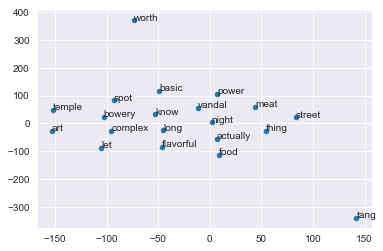

In [136]:
import numpy as np
labels = []
count = 0
max_count = 20
X = np.zeros(shape=(max_count,len(w2v_model['chicken'])))

for term in w2v_model.wv.vocab:
    X[count] = w2v_model[term]
    labels.append(term)
    count+= 1
    if count >= max_count: break

# It is recommended to use PCA first to reduce to ~50 dimensions
from sklearn.decomposition import PCA
pca = PCA(n_components=20)
X_50 = pca.fit_transform(X)

# Using TSNE to further reduce to 2 dimensions
from sklearn.manifold import TSNE
model_tsne = TSNE(n_components=2, random_state=0)
Y = model_tsne.fit_transform(X_50)

# Show the scatter plot
import matplotlib.pyplot as plt
plt.scatter(Y[:,0], Y[:,1], 20)

# Add labels
for label, x, y in zip(labels, Y[:, 0], Y[:, 1]):
    plt.annotate(label, xy = (x,y), xytext = (0, 0), textcoords = 'offset points', size = 10)

plt.show()

In [137]:
w2v_model.wv.most_similar(positive=["beef","chicken","pork"], negative=["western"], topn=3)


[('lamb', 0.931725025177002),
 ('boneless', 0.9285025000572205),
 ('spicy', 0.9235233068466187)]

In [141]:
w2v_model.wv.most_similar(positive=["beef"], topn=20)

[('lamb', 0.9635317921638489),
 ('rib', 0.9552754163742065),
 ('pork', 0.9191844463348389),
 ('bao', 0.9164900183677673),
 ('chicken_wing', 0.9124284982681274),
 ('meat', 0.9010443091392517),
 ('duck', 0.8999179601669312),
 ('roast', 0.8985037803649902),
 ('skewer', 0.8980695605278015),
 ('marinate', 0.8936108946800232),
 ('braise', 0.892594575881958),
 ('short_rib', 0.8902903199195862),
 ('grill', 0.8901416063308716),
 ('chop', 0.8869898915290833),
 ('tendon', 0.885481595993042),
 ('heart', 0.885330855846405),
 ('cheek', 0.8843792676925659),
 ('tasty', 0.8815155029296875),
 ('wing', 0.8811001181602478),
 ('tripe', 0.8782118558883667)]

In [138]:
for i in range(20):
     print(w2v_model.wv.most_similar(positive=["beef"], topn=20)[i][0], end = ', ')

fish, rib, chicken_wing, skewer, assortment, bao, usual, soup, grill, pork, serving, wing, lamb, massive, prawn, side, heart, spicy, boneless, tasty, 

In [139]:
w2v_model.wv.most_similar(positive=["beef","noodle","sushi"],negative=["chicken"], topn=20)

[('piece', 0.8354734182357788),
 ('nigiri', 0.8344287872314453),
 ('sashimi', 0.8083063960075378),
 ('omakase', 0.8077753782272339),
 ('skewer', 0.8058706521987915),
 ('raman', 0.8038617372512817),
 ('fish', 0.7919924259185791),
 ('rib', 0.7868503928184509),
 ('masa', 0.785892128944397),
 ('assortment', 0.7823796272277832),
 ('tuna', 0.7800794839859009),
 ('toro', 0.7748024463653564),
 ('o', 0.7729942798614502),
 ('seafood', 0.7725834846496582),
 ('raw', 0.764793872833252),
 ('chicken_wing', 0.7626461982727051),
 ('rotisserie', 0.7605924606323242),
 ('prawn', 0.7544761300086975),
 ('mapo', 0.7526874542236328),
 ('massive', 0.7519567012786865)]

In [140]:
for each in w2v_model.wv.most_similar(positive=["beef","noodle","sushi"],negative=["chicken"], topn=20):
    print (each[0], end = ', ')

piece, nigiri, sashimi, omakase, skewer, raman, fish, rib, masa, assortment, tuna, toro, o, seafood, raw, chicken_wing, rotisserie, prawn, mapo, massive, 

In [60]:
count=0
for each in w2v_model.wv.most_similar(positive=["beef","noodle","sushi"],negative=["chicken"], topn=50):
    if nlp(each[0])[0].pos_ != 'NOUN': #NOUN,VERB
        if count < 20:
            print (each[0], end = ', ')
            count += 1

peruvian, one, sashimi, concentrate, wide, serving, typical, average, massive, cote, compose, burrito, involve, sized, instead, consist, damn, mapo, depend, substantial, 

In [181]:
def simlar_pos(words):
    count=0
    list=[]
    for each in w2v_model.wv.most_similar(positive=words, topn=100):
        if nlp(each[0])[0].pos_ == 'NOUN': #NOUN,VERB
            if count < 20:
                list.append(each)
                count += 1
    return list

In [182]:
simlar_pos(["beef","noodle","sushi"])

[('kebab', 0.970150351524353),
 ('chow', 0.9531800150871277),
 ('nigiri', 0.9342442750930786),
 ('seafood', 0.9311694502830505),
 ('jerk', 0.927108883857727),
 ('soup', 0.9235541820526123),
 ('rib', 0.9228965044021606),
 ('momo', 0.9203916788101196),
 ('heart', 0.9172959327697754),
 ('shanghai', 0.916079044342041),
 ('fish', 0.9149395823478699),
 ('sauteed', 0.9120197892189026),
 ('roti', 0.9113460779190063),
 ('chicken', 0.9092912673950195),
 ('assortment', 0.9092251062393188),
 ('skewer', 0.903789758682251),
 ('pork', 0.9011011123657227),
 ('taco', 0.8996166586875916),
 ('pao', 0.8960884809494019),
 ('chicken_wing', 0.8939961194992065)]

In [158]:
a=[5,6,7]
print(a*3)

[5, 6, 7, 5, 6, 7, 5, 6, 7]


In [179]:
print(simlar_pos("bread"))

[('pineapple', 0.9921374917030334), ('almond', 0.9914312362670898), ('mint', 0.9907987117767334), ('herb', 0.9902586936950684), ('plum', 0.9901964664459229), ('kaffir', 0.989984929561615), ('curd', 0.9886530041694641), ('vinaigrette', 0.9885571002960205), ('dollop', 0.9884340763092041), ('blossom', 0.9877756834030151), ('shiso', 0.9872356057167053), ('cardamom', 0.9867874979972839), ('lemony', 0.9864186644554138), ('emulsion', 0.9837852120399475), ('pudding', 0.9836205244064331), ('custard', 0.9832398891448975), ('drizzle', 0.983180046081543), ('brown_butter', 0.9829319715499878), ('panna_cotta', 0.9828612208366394), ('yogurt', 0.9820305109024048)]


In [23]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [50]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=15).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('visualization for {}'.format(word.title()))

In [24]:
def tsnescatterplot1(model, word1,word2):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = []
    color_list  = []

    # adds the vector of the query word
    for wrd_score in word1:
        wrd_vector = model.wv.__getitem__([wrd_score])
        word_labels.append(wrd_score)
        color_list.append('red')
        arrays = np.append(arrays, wrd_vector, axis=0)

    
    # gets list of most similar words
    close_words = model.wv.most_similar(positive=word1,negative=word2, topn=20)
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    

        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=21).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('Similarity visualization for {} without {}'.format(word1.title(),word2.title()))

In [90]:
def tsnescatterplot2(model, word1,title):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = []
    color_list  = []

    # adds the vector of the query word
    for wrd_score in word1:
        wrd_vector = model.wv.__getitem__([wrd_score])
        word_labels.append(wrd_score)
        color_list.append('red')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar(positive=word1,topn=20)
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    

        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=len(word1)+20).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title(title)

In [ ]:
def tsnescatterplot3(model, word1,title):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = []
    color_list  = []

    # adds the vector of the query word
    for wrd_score in word1:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score)
        color_list.append('red')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar(positive=word1,topn=20)
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    

        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=len(word1)+20).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title(title)

AttributeError: 'list' object has no attribute 'title'

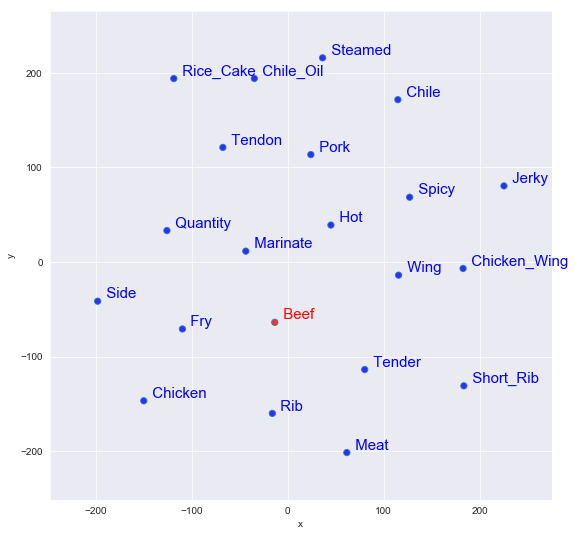

In [30]:
tsnescatterplot1(w2v_model, ["beef"],[])


In [56]:
#tsnescatterplot(w2v_model, 'beef', [i[0] for i in w2v_model.wv.most_similar(negative=["beef"])])

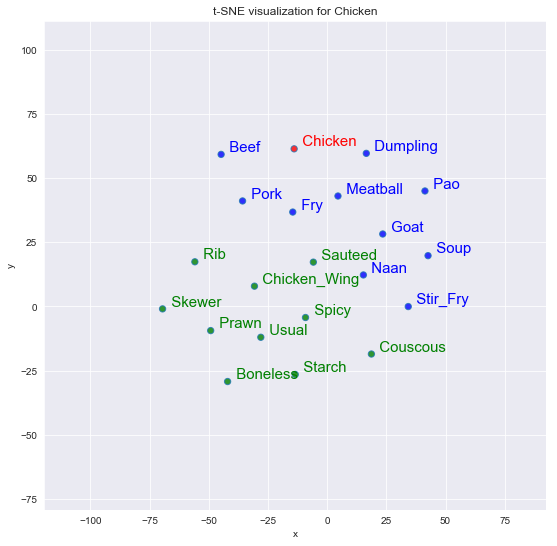

In [57]:
tsnescatterplot(w2v_model, 'chicken', [i[0] for i in w2v_model.wv.most_similar(positive=["fish"])])

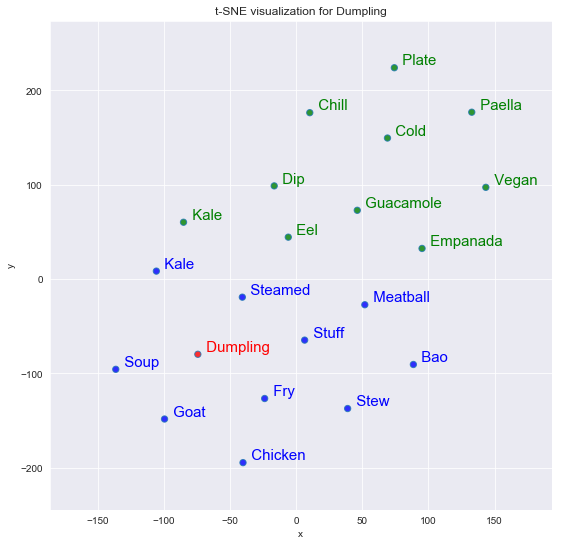

In [42]:
tsnescatterplot(w2v_model, 'dumpling', [i[0] for i in w2v_model.wv.most_similar(positive=["bread"])])

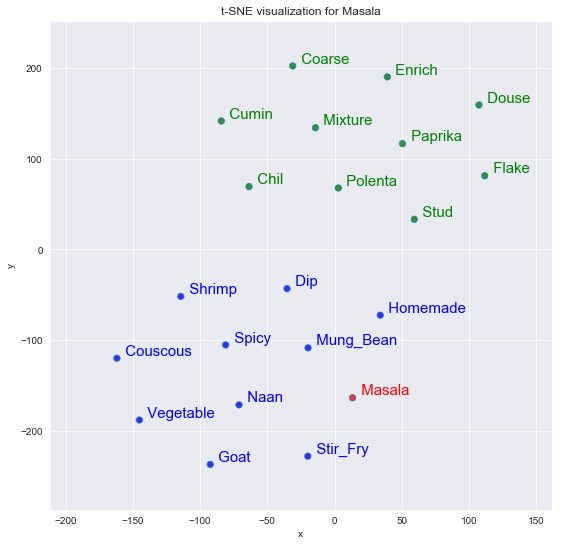

In [52]:
tsnescatterplot(w2v_model, 'masala', [i[0] for i in w2v_model.wv.most_similar(positive=["soy_sauce"])])

In [33]:
1. catagory
2. pos & neg
3. top ten similarity

SyntaxError: invalid syntax (<ipython-input-33-ac030bf80383>, line 1)

In [ ]:
unik word,more details about data, how many artical mention chicken, beef
most frequent word.
after clearing, explain dataset, compair how many is left , how many "beef" remaining

explain figure 2
explain figure TSNE or PCA
explain figure